In [62]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [63]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [64]:
estate = pd.read_csv('gurgaon-cleaned-1.csv')

In [65]:
# columns focused -> areaWithType, addtionalRoom, furnishDetails, features
estate.sample(1)

property_type                     society     sector  price  \
2153          flat  ramprastha the edge towers  sector 37   0.75   

      price_per_sqft    area                        areaWithType  bedRoom  \
2153          5319.0  1410.0  Built Up area: 1410 (130.99 sq.m.)        2   

      bathroom balcony additionalRoom  floorNum facing     agePossession  \
2153         2       3  not available      19.0    NaN  5 to 10 Year Old   

                                                                                                                                                                                                                                                                                                                              nearbyLocations  \
2153  ['MDS Public School', 'St Pauls School', 'Suncity School', 'Hanuman & Shani Mandir', 'IndusInd Bank ATM', 'SGT UHTC Basai', 'K.D. Hospital', 'CANARA BANK', 'State Bank of India', 'Basai Enclave Park', 'Ramprastha Police Post', 'Taxila cricket ground', 'Bharat Singh fuel company', 'Edge towers tennis court', 'KFG Sports Club']   

     furnishDetails features  
2153            NaN      NaN

In [66]:
# shape
estate.shape

(3814, 17)

In [67]:
# copy
df = estate.copy()

## 1. areaWithType

In [68]:
df[['area', 'areaWithType']].sample(5)

area  \
46    2315.0   
2578  1838.0   
2155  1975.0   
3576  2228.0   
1059  2103.0   

                                                                                                                areaWithType  
46                                                                                    Super Built up area 1875(174.19 sq.m.)  
2578                                                                                  Super Built up area 1828(169.83 sq.m.)  
2155                                                                                        Carpet area: 1975 (183.48 sq.m.)  
3576                                                                                        Carpet area: 2228 (206.99 sq.m.)  
1059  Super Built up area 2103(195.38 sq.m.)Built Up area: 1570 sq.ft. (145.86 sq.m.)Carpet area: 1257 sq.ft. (116.78 sq.m.)

In [69]:
# function to get super built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [70]:
# function to get built up area or carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [71]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [72]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [73]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

price property_type    area  \
978    0.42          flat   591.0   
1514   6.44         house  2430.0   
2558   0.26          flat   576.0   
1857   6.50          flat  2965.0   
2344   1.05          flat  1230.0   

                                                                                                              areaWithType  \
978                                                                                         Carpet area: 591 (54.91 sq.m.)   
1514                                                                                           Plot area 270(225.75 sq.m.)   
2558                                                                                  Super Built up area 576(53.51 sq.m.)   
1857                                                                                Super Built up area 2965(275.46 sq.m.)   
2344  Super Built up area 1230(114.27 sq.m.)Built Up area: 1200 sq.ft. (111.48 sq.m.)Carpet area: 1000 sq.ft. (92.9 sq.m.)   

      super_built_up_area  built_up_area  carpet_area  
978                   NaN            NaN        591.0  
1514                  NaN            NaN          NaN  
2558                576.0            NaN          NaN  
1857               2965.0            NaN          NaN  
2344               1230.0         1200.0       1000.0

In [74]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].shape

(534, 4)

In [75]:
df[df['areaWithType'].str.contains('Plot')][['areaWithType', 'price']].shape

(689, 2)

In [76]:
area_all_nan_df = df[df['built_up_area'].isnull() & df['super_built_up_area'].isnull() & df['carpet_area'].isnull()][['property_type', 'area','areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']]

In [77]:
area_all_nan_index = df[df['built_up_area'].isnull() & df['super_built_up_area'].isnull() & df['carpet_area'].isnull()][['areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].index

In [78]:
# extract plot area
def get_plot_area(area_type):
    pattern = re.search(r'Plot area (\d+\.?\d*)', area_type)
    if pattern:
        return float(pattern.group(1))
    else:
        None

In [79]:
# fill plot area in built up area
area_all_nan_df['built_up_area'] = area_all_nan_df['areaWithType'].apply(get_plot_area)

In [80]:
area_all_nan_df

property_type      area                     areaWithType  \
11           house    2475.0      Plot area 275(229.94 sq.m.)   
30           house    2250.0     Plot area 2250(209.03 sq.m.)   
42           house    3240.0      Plot area 360(301.01 sq.m.)   
47           house    1782.0     Plot area 1782(165.55 sq.m.)   
57           house    1440.0      Plot area 160(133.78 sq.m.)   
68           house    2700.0      Plot area 300(250.84 sq.m.)   
69           house    1557.0      Plot area 173(144.65 sq.m.)   
70           house    6228.0       Plot area 692(578.6 sq.m.)   
72           house    1053.0       Plot area 117(97.83 sq.m.)   
73           house    2642.0      Plot area 270(225.75 sq.m.)   
75           house    5490.0      Plot area 610(510.04 sq.m.)   
87           house    2844.0      Plot area 316(264.22 sq.m.)   
100          house      55.0         Plot area 55(5.11 sq.m.)   
102          house    3150.0      Plot area 350(292.64 sq.m.)   
107          house    2430.0      Plot area 270(225.75 sq.m.)   
120          house    6228.0       Plot area 692(578.6 sq.m.)   
130          house    1352.0      Plot area 160(133.78 sq.m.)   
141          house     585.0       Plot area 585(54.35 sq.m.)   
166          house    2880.0      Plot area 320(267.56 sq.m.)   
192          house    5481.0     Plot area 5480(509.11 sq.m.)   
202          house    3618.0      Plot area 402(336.12 sq.m.)   
204          house     900.0       Plot area 100(83.61 sq.m.)   
210          house    4500.0      Plot area 500(418.06 sq.m.)   
220          house    1800.0      Plot area 200(167.23 sq.m.)   
221          house    3240.0      Plot area 360(301.01 sq.m.)   
223          house    1350.0      Plot area 150(125.42 sq.m.)   
237          house    4500.0      Plot area 500(418.06 sq.m.)   
245          house     585.0        Plot area 65(54.35 sq.m.)   
250          house    4000.0     Plot area 4000(371.61 sq.m.)   
257          house    8250.0     Plot area 1000(836.13 sq.m.)   
261          house    2592.0       Plot area 288(240.8 sq.m.)   
264          house    2700.0      Plot area 300(250.84 sq.m.)   
269          house    4518.0      Plot area 502(419.74 sq.m.)   
282          house     450.0       Plot area 450(41.81 sq.m.)   
284          house    1935.0      Plot area 215(179.77 sq.m.)   
293          house    2295.0      Plot area 255(213.21 sq.m.)   
306          house    2700.0      Plot area 300(250.84 sq.m.)   
308          house    2250.0      Plot area 250(209.03 sq.m.)   
312          house    6300.0     Plot area 6300(585.29 sq.m.)   
332          house    1800.0      Plot area 200(167.23 sq.m.)   
335          house     540.0       Plot area 540(50.17 sq.m.)   
336          house    4466.0      Plot area 502(419.74 sq.m.)   
338          house    2700.0      Plot area 300(250.84 sq.m.)   
339          house    2500.0     Plot area 2500(232.26 sq.m.)   
342          house    2250.0      Plot area 250(209.03 sq.m.)   
351          house    1800.0      Plot area 200(167.23 sq.m.)   
359          house    2700.0      Plot area 300(250.84 sq.m.)   
380          house    2160.0      Plot area 240(200.67 sq.m.)   
387          house    5000.0     Plot area 5000(464.52 sq.m.)   
391          house     150.0       Plot area 150(13.94 sq.m.)   
392          house     600.0       Plot area 600(55.74 sq.m.)   
393          house    3240.0      Plot area 360(301.01 sq.m.)   
414          house     684.0       Plot area 684(63.55 sq.m.)   
416          house    2367.0       Plot area 263(219.9 sq.m.)   
422          house    3240.0      Plot area 360(301.01 sq.m.)   
425          house    1783.0  Plot area 1782.72(165.62 sq.m.)   
434          house     785.0       Plot area 785(72.93 sq.m.)   
447          house    1160.0     Plot area 1160(107.77 sq.m.)   
449          house       NaN     Plot area 2700(250.84 sq.m.)   
453          house    3150.0      Plot area 350(292.64 sq.m.)   
460          house    1665.0      Plot a

In [81]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [82]:
area_all_nan_df['built_up_area'] = area_all_nan_df.apply(convert_scale, axis = 1)

In [83]:
area_all_nan_df

property_type      area                     areaWithType  \
11           house    2475.0      Plot area 275(229.94 sq.m.)   
30           house    2250.0     Plot area 2250(209.03 sq.m.)   
42           house    3240.0      Plot area 360(301.01 sq.m.)   
47           house    1782.0     Plot area 1782(165.55 sq.m.)   
57           house    1440.0      Plot area 160(133.78 sq.m.)   
68           house    2700.0      Plot area 300(250.84 sq.m.)   
69           house    1557.0      Plot area 173(144.65 sq.m.)   
70           house    6228.0       Plot area 692(578.6 sq.m.)   
72           house    1053.0       Plot area 117(97.83 sq.m.)   
73           house    2642.0      Plot area 270(225.75 sq.m.)   
75           house    5490.0      Plot area 610(510.04 sq.m.)   
87           house    2844.0      Plot area 316(264.22 sq.m.)   
100          house      55.0         Plot area 55(5.11 sq.m.)   
102          house    3150.0      Plot area 350(292.64 sq.m.)   
107          house    2430.0      Plot area 270(225.75 sq.m.)   
120          house    6228.0       Plot area 692(578.6 sq.m.)   
130          house    1352.0      Plot area 160(133.78 sq.m.)   
141          house     585.0       Plot area 585(54.35 sq.m.)   
166          house    2880.0      Plot area 320(267.56 sq.m.)   
192          house    5481.0     Plot area 5480(509.11 sq.m.)   
202          house    3618.0      Plot area 402(336.12 sq.m.)   
204          house     900.0       Plot area 100(83.61 sq.m.)   
210          house    4500.0      Plot area 500(418.06 sq.m.)   
220          house    1800.0      Plot area 200(167.23 sq.m.)   
221          house    3240.0      Plot area 360(301.01 sq.m.)   
223          house    1350.0      Plot area 150(125.42 sq.m.)   
237          house    4500.0      Plot area 500(418.06 sq.m.)   
245          house     585.0        Plot area 65(54.35 sq.m.)   
250          house    4000.0     Plot area 4000(371.61 sq.m.)   
257          house    8250.0     Plot area 1000(836.13 sq.m.)   
261          house    2592.0       Plot area 288(240.8 sq.m.)   
264          house    2700.0      Plot area 300(250.84 sq.m.)   
269          house    4518.0      Plot area 502(419.74 sq.m.)   
282          house     450.0       Plot area 450(41.81 sq.m.)   
284          house    1935.0      Plot area 215(179.77 sq.m.)   
293          house    2295.0      Plot area 255(213.21 sq.m.)   
306          house    2700.0      Plot area 300(250.84 sq.m.)   
308          house    2250.0      Plot area 250(209.03 sq.m.)   
312          house    6300.0     Plot area 6300(585.29 sq.m.)   
332          house    1800.0      Plot area 200(167.23 sq.m.)   
335          house     540.0       Plot area 540(50.17 sq.m.)   
336          house    4466.0      Plot area 502(419.74 sq.m.)   
338          house    2700.0      Plot area 300(250.84 sq.m.)   
339          house    2500.0     Plot area 2500(232.26 sq.m.)   
342          house    2250.0      Plot area 250(209.03 sq.m.)   
351          house    1800.0      Plot area 200(167.23 sq.m.)   
359          house    2700.0      Plot area 300(250.84 sq.m.)   
380          house    2160.0      Plot area 240(200.67 sq.m.)   
387          house    5000.0     Plot area 5000(464.52 sq.m.)   
391          house     150.0       Plot area 150(13.94 sq.m.)   
392          house     600.0       Plot area 600(55.74 sq.m.)   
393          house    3240.0      Plot area 360(301.01 sq.m.)   
414          house     684.0       Plot area 684(63.55 sq.m.)   
416          house    2367.0       Plot area 263(219.9 sq.m.)   
422          house    3240.0      Plot area 360(301.01 sq.m.)   
425          house    1783.0  Plot area 1782.72(165.62 sq.m.)   
434          house     785.0       Plot area 785(72.93 sq.m.)   
447          house    1160.0     Plot area 1160(107.77 sq.m.)   
449          house       NaN     Plot area 2700(250.84 sq.m.)   
453          house    3150.0      Plot area 350(292.64 sq.m.)   
460          house    1665.0      Plot a

In [84]:
# update to original df
df.update(area_all_nan_df)

In [85]:
df.isnull().sum()

property_type             0
society                 491
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 20
facing                 1109
agePossession             1
nearbyLocations         178
furnishDetails          985
features                639
super_built_up_area    1898
built_up_area          2074
carpet_area            1867
dtype: int64

## 2. additionalRoom

In [86]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1592
servant room                                      705
study room                                        251
others                                            226
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 56
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              23
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [87]:
# create new cols in dataframe 
new_cols = ['servant room', 'study room', 'pooja room', 'store room', 'others']
# fill value on the based of additonalRoom
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [88]:
df[['additionalRoom', 'servant room', 'study room', 'pooja room', 'store room', 'others']].sample(10)

additionalRoom  servant room  study room  \
620                                    servant room             1           0   
2280                        study room,servant room             1           1   
1135                        servant room,pooja room             1           0   
987                                   not available             0           0   
689                                      pooja room             0           0   
3051                                  not available             0           0   
818                                   not available             0           0   
631   pooja room,study room,servant room,store room             1           1   
1189  study room,servant room,pooja room,store room             1           1   
2282                                  not available             0           0   

      pooja room  store room  others  
620            0           0       0  
2280           0           0       0  
1135           1           0       0  
987            0           0       0  
689            1           0       0  
3051           0           0       0  
818            0           0       0  
631            1           1       0  
1189           1           1       0  
2282           0           0       0

## 3. agePossession

In [89]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1678
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           316
Under Construction      91
Within 6 months         70
Within 3 months         26
Dec-23                  22
By 2023                 19
By 2024                 17
Dec-24                  16
Mar-24                  14
Jan-24                   8
Oct-24                   8
Aug-23                   7
Dec-25                   7
Jun-24                   7
Nov-23                   5
Aug-24                   5
Jan-25                   4
Oct-23                   4
Jul-24                   4
Sep-23                   4
By 2025                  4
May-24                   3
Feb-24                   3
Nov-24                   3
Jul-27                   2
Dec-26                   2
Jan-26                   2
Aug-25                   2
Mar-25                   2
Jul-25                   2
Sep-25                   2
Apr-26                   2
By 2027       

In [90]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [91]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [92]:
df['agePossession'].value_counts()

agePossession
Relatively New        1678
New Property           626
Moderately Old         575
Undefined              486
Old Property           316
Under Construction     133
Name: count, dtype: int64

## 4. furnishDetails

In [93]:
df[['furnishDetails', 'features']]

furnishDetails  \
0                                                                                                                                                                                                                                                                       NaN   
1            ['4 Wardrobe', '4 Fan', '1 Exhaust Fan', '4 Geyser', '15 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']   
2                                                                                                                                                                                                                                                                       NaN   
3                                                                                                                                                                                                                                                                       NaN   
4                     ['1 Water Purifier', '6 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '6 Geyser', '1 Stove', '19 Light', '6 AC', '5 TV', '1 Modular Kitchen', '1 Chimney', '5 Curtains', '4 Wardrobe', '1 Sofa', '1 Washing Machine', '1 Microwave', 'No Bed']   
5                                                                                                                                                                                                                                                                       NaN   
6      ['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
7      ['6 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
8                                                                                                                                                                                                                                                                       NaN   
9                                                                                                                                                                                                                                                                       NaN   
10     ['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
11                   ['1 Water Purifier', '10 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '7 Geyser', '1 Stove', '14 Light', '1 Modular Kitchen', '7 TV', '1 Curtains', '1 Chimney', '7 Wardrobe', '7 Bed', '1 Sofa', '1 Washing Machine', '1 Microwave', 'No AC']   
12     ['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
13                                                                                                                                                                                                                                                                       []   
14     ['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa',

In [94]:
import re

# Step 1: Find all unique furnishings mentioned in the column
all_furnishings = []
for text in df['furnishDetails'].dropna():
    items = text.replace('[','').replace(']','').replace("'", "").split(', ')
    all_furnishings.extend(items)

# Clean names: remove "No" and numbers
unique_items = set()
for item in all_furnishings:
    name = re.sub(r'No |\d+', '', item).strip()
    if name:
        unique_items.add(name)

# Step 2: Function to count how many of each furnishing is present
def count_furnishing(text, item):
    if not isinstance(text, str):
        return 0
    if f"No {item}" in text:
        return 0
    match = re.search(rf"(\d+)\s+{item}", text)
    if match:
        return int(match.group(1))
    return 1 if item in text else 0

# Step 3: Create a column for each furnishing
for item in unique_items:
    df[item] = df['furnishDetails'].apply(lambda x: count_furnishing(x, item))

# Step 4: Make the final DataFrame
furnishings_df = df[['furnishDetails'] + list(unique_items)]

In [95]:
furnishings_df.sample(2)

furnishDetails  \
2520       ['4 Fan', '1 Exhaust Fan', '3 Geyser', '6 Light', '3 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
565   ['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   

      AC  Water Purifier  Microwave  Geyser  Exhaust Fan  Stove  Light  \
2520   3               0          0       3            1      0      6   
565    0               0          0       0            0      0      1   

      Wardrobe  Fan  Modular Kitchen  Curtains  Dining Table  Fridge  \
2520         0    4                1         0             0       0   
565          0    0                0         0             0       0   

      Washing Machine  Bed  TV  Chimney  Sofa  
2520                0    0   0        0     0  
565                 0    0   0        0     0

In [96]:
furnishings_df.shape

(3814, 19)

In [97]:
furnishings_df.drop(columns = ['furnishDetails'], inplace = True)

In [98]:
furnishings_df.sample(5)

AC  Water Purifier  Microwave  Geyser  Exhaust Fan  Stove  Light  \
3075   6               0          1       5            1      1     10   
1027   6               0          0       0            0      0      0   
3799   1               1          0       1            0      0      8   
1230   0               0          0       2            1      0      7   
1030   0               0          0       2            1      0      7   

      Wardrobe  Fan  Modular Kitchen  Curtains  Dining Table  Fridge  \
3075         5    7                1         0             0       0   
1027         0    0                1         0             0       0   
3799         1    2                1         8             0       1   
1230         4    6                1         0             0       0   
1030         3    3                1         0             0       0   

      Washing Machine  Bed  TV  Chimney  Sofa  
3075                0    0   0        1     0  
1027                0    0   0        1     0  
3799                0    0   0        0     0  
1230                0    0   0        1     0  
1030                0    0   0        1     0

In [99]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [100]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [101]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

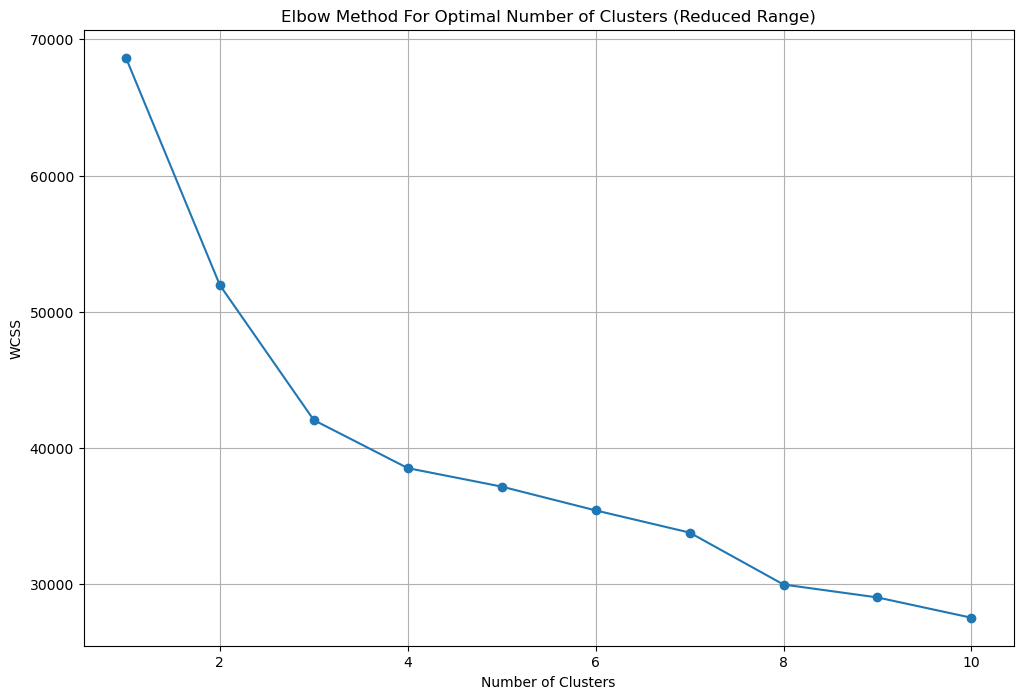

In [102]:
# Plot the results
plt.figure(figsize = (12, 8))
plt.plot(range(1,11), wcss_reduced, marker = 'o', linestyle = '-')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [103]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
kmeans.fit(scaled_data)

# Predict the data for each row
cluster_data = kmeans.predict(scaled_data)

In [104]:
df.sample(1)

property_type     society      sector  price  price_per_sqft    area  \
3322          flat  paras dews  sector 106   1.35          8940.0  1510.0   

                          areaWithType  bedRoom  bathroom balcony  \
3322  Carpet area: 1510 (140.28 sq.m.)        4         3       3   

     additionalRoom  floorNum facing agePossession  \
3322   servant room      19.0    NaN  Old Property   

                                                                                                                                                                                                                                                                                  nearbyLocations  \
3322  ['MG Road Metro Station', 'NeoSquare Shopping Mall', 'Dwarka Expressway', 'Glorious World School', 'DPG Institute of Technology', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Gurgaon', 'Country Inn & Suites by Radisson', 'SkyJumper Trampoline Park', 'Hamoni Golf Camp']   

     furnishDetails  \
3322            NaN   

                                                                                                                                                                                                                                                                                                                                                                                                    features  \
3322  ['Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center']   

      super_built_up_area  built_up_area  carpet_area  servant room  \
3322                  NaN            NaN       1510.0             1   

      study room  pooja room  store room  others  AC  Water Purifier  \
3322           0           0           0       0   0               0   

      Microwave  Geyser  Exhaust Fan  Stove  Light  Wardrobe  Fan  \
3322          0       0            0      0      0         0    0   

      Modular Kitchen  Curtains  Dining Table  Fridge  Washing Machine  Bed  \
3322                0         0             0       0                0    0   

      TV  Chimney  Sofa  
3322   0        0     0

In [105]:
# remove last 18 columns
df = df.iloc[:,:-18]

In [106]:
# add new col furnished type 
df['furnished_type'] = cluster_data

In [107]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df.sample(5)[['furnishDetails','furnished_type']]

furnishDetails  \
1762                                                                                                                                                                                                                                                                NaN   
1597  ['3 Fan', '1 Exhaust Fan', '1 Dining Table', '3 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   
2895                                                                                                                                                                                                                                                                NaN   
1494                                                                                                                                                                                                                                                                NaN   
2147     ['6 Fan', '1 Exhaust Fan', '1 Stove', '5 Light', '6 AC', '1 Chimney', '1 Modular Kitchen', 'No Bed', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']   

      furnished_type  
1762               0  
1597               0  
2895               0  
1494               0  
2147               1

In [108]:
# furnised type should be 0 for nan and [] values 
df[df['furnishDetails'].isnull()][['furnishDetails', 'furnished_type']].shape

(985, 2)

In [109]:
df[df['furnishDetails'] == '[]'][['furnishDetails', 'furnished_type']].shape

(422, 2)

In [110]:
df.loc[df['furnishDetails'].isna() | (df['furnishDetails'] == '[]'), 'furnished_type'] = 0

In [111]:
df[df['furnishDetails'].isnull()][['furnishDetails', 'furnished_type']]

furnishDetails  furnished_type
0               NaN               0
2               NaN               0
3               NaN               0
5               NaN               0
8               NaN               0
9               NaN               0
16              NaN               0
19              NaN               0
23              NaN               0
27              NaN               0
32              NaN               0
37              NaN               0
43              NaN               0
48              NaN               0
49              NaN               0
53              NaN               0
54              NaN               0
62              NaN               0
70              NaN               0
82              NaN               0
89              NaN               0
90              NaN               0
94              NaN               0
96              NaN               0
100             NaN               0
107             NaN               0
108             NaN               0
111             NaN               0
119             NaN               0
121             NaN               0
122             NaN               0
123             NaN               0
135             NaN               0
136             NaN               0
138             NaN               0
143             NaN               0
145             NaN               0
149             NaN               0
150             NaN               0
151             NaN               0
153             NaN               0
161             NaN               0
175             NaN               0
178             NaN               0
181             NaN               0
182             NaN               0
192             NaN               0
197             NaN               0
200             NaN               0
205             NaN               0
209             NaN               0
214             NaN               0
216             NaN               0
218             NaN               0
223             NaN               0
225             NaN               0
228             NaN               0
230             NaN               0
248             NaN               0
251             NaN               0
262             NaN               0
273             NaN               0
275             NaN               0
276             NaN               0
293             NaN               0
296             NaN               0
303             NaN               0
308             NaN               0
309             NaN               0
311             NaN               0
313             NaN               0
316             NaN               0
317             NaN               0
321             NaN               0
323             NaN               0
325             NaN               0
326             NaN               0
329             NaN               0
335             NaN               0
344             NaN               0
349             NaN               0
351             NaN               0
355             NaN               0
357             NaN               0
366             NaN               0
368             NaN               0
370             NaN               0
372             NaN               0
373             NaN               0
375             NaN               0
386             NaN               0
387             NaN               0
395             NaN               0
396             NaN               0
398             NaN               0
411             NaN               0
413             NaN               0
414             NaN               0
424             NaN               0
428             NaN               0
429             NaN               0
434             NaN               0
436             NaN               0
437             NaN               0
445             NaN               0
446             NaN               0
451             NaN               0
454             NaN               0
456             NaN               0
458             NaN               0
460      

In [112]:
df[df['furnishDetails'] == '[]'][['furnishDetails', 'furnished_type']]

furnishDetails  furnished_type
13               []               0
25               []               0
29               []               0
34               []               0
35               []               0
39               []               0
41               []               0
46               []               0
47               []               0
61               []               0
75               []               0
78               []               0
98               []               0
101              []               0
116              []               0
118              []               0
129              []               0
137              []               0
147              []               0
148              []               0
173              []               0
176              []               0
180              []               0
187              []               0
188              []               0
191              []               0
193              []               0
202              []               0
207              []               0
219              []               0
224              []               0
227              []               0
231              []               0
256              []               0
263              []               0
267              []               0
281              []               0
282              []               0
288              []               0
291              []               0
299              []               0
318              []               0
319              []               0
345              []               0
354              []               0
358              []               0
361              []               0
363              []               0
369              []               0
379              []               0
381              []               0
390              []               0
392              []               0
403              []               0
407              []               0
408              []               0
421              []               0
441              []               0
453              []               0
462              []               0
470              []               0
474              []               0
478              []               0
482              []               0
483              []               0
487              []               0
490              []               0
497              []               0
513              []               0
544              []               0
547              []               0
561              []               0
591              []               0
627              []               0
641              []               0
652              []               0
667              []               0
675              []               0
684              []               0
695              []               0
706              []               0
718              []               0
727              []               0
728              []               0
729              []               0
732              []               0
739              []               0
740              []               0
760              []               0
761              []               0
762              []               0
765              []               0
830              []               0
833              []               0
842              []               0
846              []               0
848              []               0
852              []               0
856              []               0
867              []               0
870              []               0
889              []               0
890              []               0
901              []               0
902              []               0
905              []               0
908              []               0
918              []               0
920              []               0
929              []               0
937      

## 5. features 

In [113]:
df[['features']].sample(5)

features
2889                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   NaN
3520                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Water Storage', 'Park', 'Visitor Parking', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']
955                                                                                                ['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']
3450                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ['Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']
1753  ['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']

In [114]:
df['features'].isnull().sum()

np.int64(639)

In [115]:
apartments = pd.read_csv('apartments.csv')
apartments.sample(2)

PropertyName                         PropertySubName  \
186  Anant Raj Ashok Estate             Land in Sector 63A, Gurgaon   
241      Suncity Avenue 102  2 BHK Apartment in Sector 102, Gurgaon   

                                                                                                                                             NearbyLocations  \
186  ['Paras Trinity Mall', 'Heritage Xperiential Learning School', 'W Pratiksha Hospital', 'Sector 55-56 Metro Station', 'BM College of Technology & Mgmt']   
241                                                                 ['Delhi International Airport', 'AIIMS', 'The Hive', 'Gurugram Rd', 'JMS Marine Square']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               LocationAdvantages  \
186                                                                                                                                                                                                                                        {'Paras Trinity Mall': '2.3 KM', 'Heritage Xperiential Learning School': '3 KM', 'W Pratiksha Hospital': '3.6 KM', 'Sector 55-56 Metro Station': '3.7 KM', 'BM College of Technology & Mgmt': '9.6 KM', 'NH 248A': '11.4 KM', 'Indira Gandhi Intl Airport': '23.1 KM'}   
241  {'Delhi International Airport': '34 minutes drive', 'AIIMS': '26 minutes drive', 'The Hive': '5 minutes drive', 'Gurugram Rd': 'In close proximity', 'JMS Marine Square': '8 minutes drive', 'Stymerra Chowk': '8 minutes drive', 'Sector 102 Dhankot': '5 minutes drive', 'Shri Hanuman Ji Mandir': '5 minutes drive', 'MCC Cricket Ground Dhankot': '6 minutes drive', 'KFG Sports Club': '8 minutes drive', 'Signature Hospital': '10 minutes drive', 'Prime Scholars Int. School': 'In close proximity'}   

                                                                                Link  \
186  https://www.99acres.com/anant-raj-ashok-estate-sector-63a-gurgaon-npxid-r396054   
241      https://www.99acres.com/suncity-avenue-102-sector-102-gurgaon-npxid-r256209   

                                                                                                                                       PriceDetails  \
186                                    {'Land': {'building_type': '', 'area_type': 'Plot Area', 'area': '1,620 sq.ft.', 'price-range': '₹ 3.8 Cr'}}   
241  {'2 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '605.5 - 632 sq.ft.', 'price-range': 'Price on Request'}}   

                                                                                                                                                           TopFacilities  
186                                                                                                                                                  ['Gated Community']  
241  ['Creche/Day care', 'Property Staff', 'Multipurpose Court', 'Community Hall', 'Multipurpose Hall', 'Gated Community', 'Landscape Garden', 'Lift(s)', 'Car Parking']

In [116]:
apartments['PropertyName'] = apartments['PropertyName'].str.lower()

In [117]:
apartments['PropertyName'].value_counts()

PropertyName
smartworld one dxp                              1
m3m crown                                       1
adani brahma samsara vilasa                     1
sobha city                                      1
signature global city 93                        1
whiteland the aspen                             1
bestech altura                                  1
elan the presidential                           1
signature global city 92                        1
emaar digihomes                                 1
signature global city 79b                       1
dlf the arbour                                  1
m3m antalya hills                               1
signature global city 81                        1
ss linden floors                                1
mahindra luminare                               1
m3m golf hills                                  1
suncity vatsal valley                           1
whiteland blissville                            1
trump tower                          

In [118]:
temp_df = df[df['features'].isnull()]

In [119]:
x = temp_df.merge(apartments, left_on = 'society', right_on = 'PropertyName', how = 'left')['TopFacilities']

In [120]:
df.loc[temp_df.index, 'features'] = x.values

In [121]:
df['features'].isnull().sum()

np.int64(485)

In [122]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}

In [123]:
import ast
df["features"] = df["features"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [124]:
# function to assign weight to the facilites 
def calculate_luxury_score(facilities):
    if isinstance(facilities, list):
        return sum(weights.get(fac, 0) for fac in facilities)
    return 0 

In [125]:
df['luxury_score'] = df['features'].apply(calculate_luxury_score)

In [126]:
df.sample(1)

property_type               society     sector  price  price_per_sqft  \
330          flat  park royal apartment  sector 56   1.71          7600.0   

       area  \
330  2250.0   

                                                                  areaWithType  \
330  Built Up area: 2251 (209.12 sq.m.)Carpet area: 2250 sq.ft. (209.03 sq.m.)   

     bedRoom  bathroom balcony additionalRoom  floorNum      facing  \
330        3         3      3+   servant room       5.0  North-East   

      agePossession  \
330  Moderately Old   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 nearbyLocations  \
330  ['Sector metro station', 'Sector metro station', 'Sector 54 chowk metro station', 'Radhakrishna Shani Mandir', 'Sanatan Dharm Mandir', 'Icici bank ATM', 'State bank ATM', 'Icici bank ATM', 'Citi bank ATM', 'Indusind bank ATM', 'pracksht hospital', 'Kriti Hospital', 'Anand Hospital Gurgaon', 'Surgicare Hospital Gurgaon', 'Arunodaya Deseret Eye Hospital', 'Vatsalya Clinic', 'HUDA Office Complex', 'Medisca', 'Apollo Pharmacy', 'Intellion Park', 'International Tech Park', 'Heera Fuel Station', 'HCG CNG Station', 'Hdfc bank and atm', 'Hdfc bank', 'Kotak mahindra bank', 'State bank of india', 'Indusind bank', 'Axis bank', 'Icici bank', 'Hdfc bank', 'Hdfc bank & atm', '222', 'Pizza Hut', 'Wat-a-Burger', 'Burger Singh', 'Bikanerwala', 'Naivedyam Restaurant', 'Madison and Pike', 'IILM', 'Iilm University', 'Sushant College of Arts & Architecture', 'Ansal Institute of Technology', 'Suncity School', 'Gurugram University']   

                                                                                                                                                                                                                                                     furnishDetails  \
330  ['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Geyser', '9 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']   

                                                                                                                                                                                                                                                                                                                                                              features  \
330  [Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), High Ceiling Height, Maintenance Staff, Water Storage, Separate entry for servant room, Piped-gas, Visitor Parking, Park, Security Personnel, Natural Light, Internet/wi-fi connectivity, Airy Rooms, Spacious Interiors, Low Density Society, Shopping Centre, Waste Disposal, Rain Water Harvesting]   

     super_built_up_area  built_up_area  carpet_area  servant room  \
330                  NaN         2251.0       2250.0             1   

     study room  pooja room  store room  others  furnished_type  luxury_score  
330           0           0           0       0               1           118

In [127]:
df.sample(1)

property_type           society   sector  price  price_per_sqft    area  \
675          flat  aditya apartment  manesar    1.0          4033.0  2480.0   

                          areaWithType  bedRoom  bathroom balcony  \
675  Built Up area: 2480 (230.4 sq.m.)        3         4       0   

    additionalRoom  floorNum facing agePossession  \
675  not available       3.0    NaN  New Property   

                                                                                                                                                                                                                                                                                      nearbyLocations  \
675  ['Sagar Clinic', 'Shree Balaji Clinic', 'Promla Clinic', 'Rathore Imt Hospital', 'Kushi Clinic', 'Dr. J. S. Sarkar Clinic', 'Bangali Clinic', 'Nidan Hospital and Trauma Centre', 'Sercare Clinic', 'Yadav Clinic', 'Ragave Clinic', 'Ram Clinic', 'Om Clinic', 'Amba Clinic', "Domino's Pizza"]   

    furnishDetails features  super_built_up_area  built_up_area  carpet_area  \
675             []      NaN                  NaN         2480.0          NaN   

     servant room  study room  pooja room  store room  others  furnished_type  \
675             0           0           0           0       0               0   

     luxury_score  
675             0

In [128]:
# cols to drop -> nearbyLocations, features, furnishDetails, 
df.drop(columns = ['nearbyLocations', 'furnishDetails', 'features', 'additionalRoom'], inplace = True)

In [129]:
df.to_csv('gurgaon-cleaned-2.csv', index = False)